<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/09_pytorch_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Deploy de Modelow

Pra q serve?

Para deixar o codigo que esta no notebook em algo usavel por outros/outra coisa.




## 0. Importando os basicos

* Pacotes
* E baixandos o going_modular do github

In [1]:
#ctrl c + ctrl v dos imports pardrao
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 255 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 36.72 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Baixando os dados

In [3]:
#ctrl c + ctrl v dos imports pardrao
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
#ctrl c + ctrl v dos imports pardrao
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. Experimentos para o Deploy do FoodVisiob Mini

### 3 Perguntas a serem respondidas?

1. QUal o melhor cenario para o deploy desse modeelo de machine learning?
2. Para aondemeu modelo ira?
3. Como o modelo ira funcionar?

**USo ideal do FoodVision Mini:**  Um modelo que performa bem e seeja rapido
  1. PErformace: 95%+ de acurácia
  2. Rapdo: O mais perto de real-time possivel (30FPS+ ou 30ms de latencia)

Para conseguir sses objetivos serao realizados eexperimentos em dois modelos:
  1. EffNetBB2
  2. ViT  

## 3. Criando um extrator de caracteristicas EffNetB2

extrator de caracteristicas = Um termo para "transer learning", aonde o modelo tem suas camadas bases congeladas e saida customizada para o problema em questao.

In [5]:
#PEgando os pesos
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#PEgando os transforms
efnetb2_transforms = effnetb2_weights.transforms()

#Instanciando um model effnet com os pesos DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

#COngelando as camadas baes
for param in effnetb2.parameters():
 param.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 74.3MB/s]


In [6]:
from torchinfo import summary

 # Print EffNetB2 model summary (uncomment for full output)
saidas = summary(effnetb2,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])
#saidas

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
set_seeds()
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408, out_features=3))

In [9]:
 # Print EffNetB2 model summary (uncomment for full output)
saidas2 = summary(effnetb2,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])
saidas2

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Criando uma funcao para criar um modelo de extracao de caracteristicas EffNetB2

In [10]:
def create_effnetb2(num_classes:int = 3,
                    seed:int=3):

  # Pesos, transforms, e instanciando o modelo
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #COngelando as camdas base
  for param in model.parameters():
    requires_grad=False

  #AJustando o classifier para o problema em questao
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=3))

  return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2(num_classes=3, seed=42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#COnfigurando Dataloaders pra o EffNetB2


In [14]:
from going_modular.going_modular import data_setup

train_datalaoder_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [15]:
len(train_datalaoder_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### Treinado o extrator de caracteristicas EffNetB2

In [16]:
from going_modular.going_modular import engine
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

modelo = engine.train(model=effnetb2,
                      train_dataloader=train_datalaoder_effnetb2,
                      test_dataloader=test_dataloader_effnetb2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4206 | train_acc: 0.8438 | test_loss: 0.2970 | test_acc: 0.9125
Epoch: 2 | train_loss: 0.1538 | train_acc: 0.9313 | test_loss: 0.0888 | test_acc: 0.9563
Epoch: 3 | train_loss: 0.1798 | train_acc: 0.9458 | test_loss: 0.0837 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.4032 | train_acc: 0.9292 | test_loss: 0.1416 | test_acc: 0.9477
Epoch: 5 | train_loss: 0.0964 | train_acc: 0.9854 | test_loss: 0.1850 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.1712 | train_acc: 0.9354 | test_loss: 0.1887 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.2173 | train_acc: 0.9479 | test_loss: 0.1972 | test_acc: 0.9324
Epoch: 8 | train_loss: 0.1195 | train_acc: 0.9542 | test_loss: 0.1274 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.1550 | train_acc: 0.9625 | test_loss: 0.2542 | test_acc: 0.9108
Epoch: 10 | train_loss: 0.1212 | train_acc: 0.9583 | test_loss: 0.3544 | test_acc: 0.8557


### 3.4 Inspecionando os curvas da EffNetB2


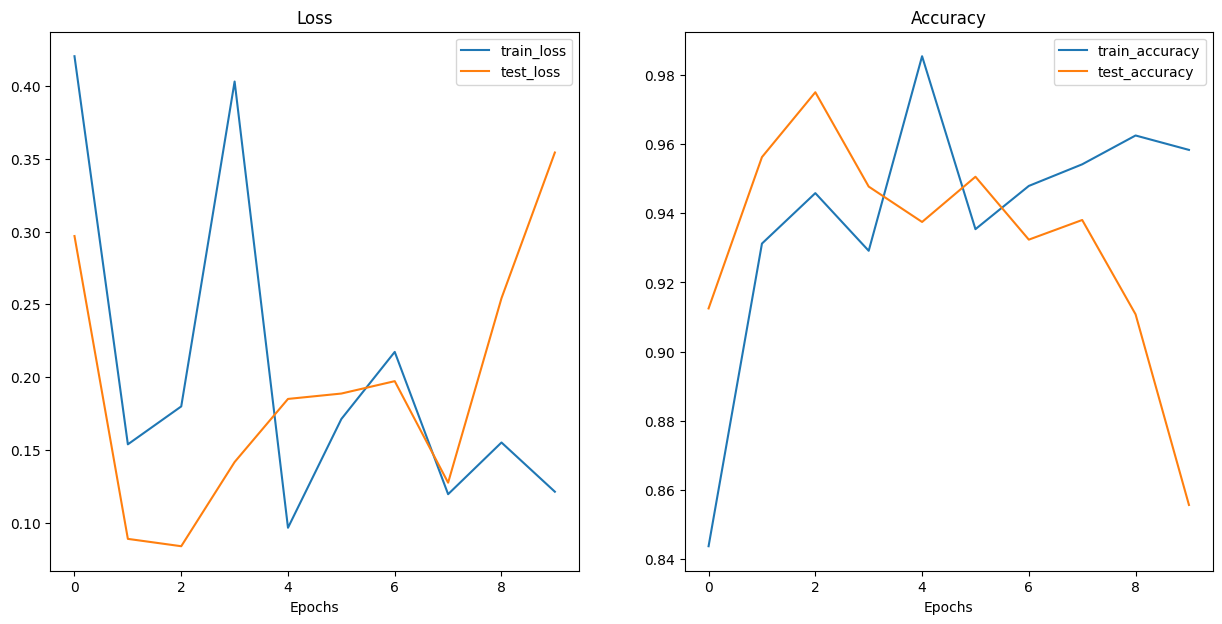

In [17]:
from helper_functions import plot_loss_curves
plot_loss_curves(modelo)

### 3.5 Salvando o modelo EffNetB2


In [18]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Descobrindo o tamanho do arquivo do modelo

Pq isso e importante?

Pq estamos lancando esse modelo pra ser usado em um app/mobile que pode ter limitacoes de recurcos computacionais. Assim se o modelo for muit grande (para os dispositivos em questao) ele pode nao rodar/ ter problemas ao rodar.


In [19]:
from pathlib import Path

#Pegando o tamanho em bytes e convertendo para mega
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Tamanho do modelo {round(pretrained_effnetb2_model_size, 2)}MB")

Tamanho do modelo 29MB


### 3.7 Estatisticas do extrator de caracteristicas da EffNetB2

In [20]:
#Contagem da quantidade de parametros
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [21]:
#Criando um dicionarios com os resultados do treinamento do modelo para posterior comparacao
effnetb2_stats = {"test_loss": modelo["test_loss"][-1],
                  "test_acc": modelo["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.35438397377729414,
 'test_acc': 0.8556818181818182,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Criando um extrator de caracteristicas usando o ViT

In [22]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit_transforms = vit_weights.transforms()

vit = torchvision.models.vit_b_16(weights=vit_weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 170MB/s]


In [23]:
for param in vit.parameters():
  requires_grad=False

In [24]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [25]:
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [26]:
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
)

In [27]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [28]:
def create_vit(out_features:int=3, seed:int=42):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  vit_transforms = vit_weights.transforms()

  vit = torchvision.models.vit_b_16(weights=vit_weights)

  for param in vit.parameters():
    param.requires_grad=False

  vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3)
    )

  return vit, vit_transforms

In [29]:
vit, vit_transform = create_vit(out_features=3,
           seed=42)
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [30]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Criando os DataLoaders para a ViT

In [31]:
train_vit_dataloader, test_vit_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transform,
                                                                                       batch_size=32)
len(train_vit_dataloader), len(test_vit_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Treinando a ViT

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)


In [33]:
vit_results = engine.train(model=vit,
                           train_dataloader=train_vit_dataloader,
                           test_dataloader=test_vit_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5945 | train_acc: 0.8146 | test_loss: 0.2363 | test_acc: 0.9506
Epoch: 2 | train_loss: 0.2109 | train_acc: 0.9437 | test_loss: 0.1248 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1507 | train_acc: 0.9563 | test_loss: 0.0940 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1203 | train_acc: 0.9646 | test_loss: 0.0787 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1029 | train_acc: 0.9750 | test_loss: 0.0735 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.0884 | train_acc: 0.9750 | test_loss: 0.0686 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0732 | train_acc: 0.9812 | test_loss: 0.0655 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0641 | train_acc: 0.9875 | test_loss: 0.0626 | test_acc: 0.9812
Epoch: 9 | train_loss: 0.0574 | train_acc: 0.9938 | test_loss: 0.0591 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.0528 | train_acc: 0.9938 | test_loss: 0.0580 | test_acc: 0.9812


### 4.3 Plotando as curvas do treinamento

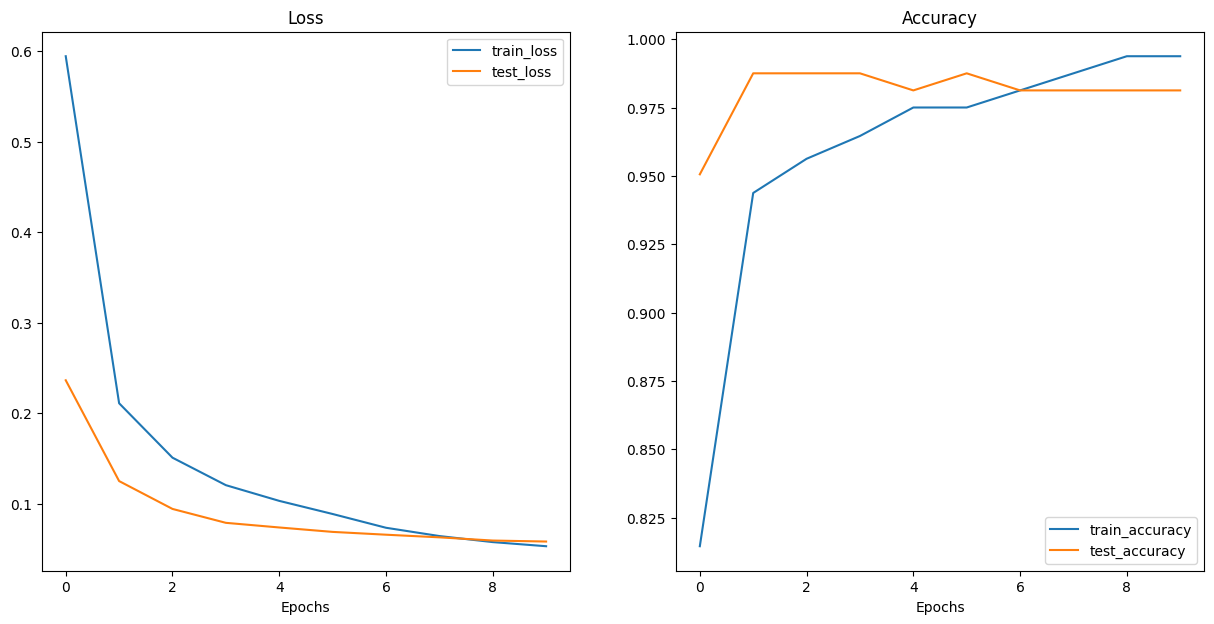

In [34]:
plot_loss_curves(vit_results)

In [35]:
utils.save_model(model=vit,
                 target_dir='models',
                model_name="09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth


In [36]:
tamanho_modelo= Path("models/09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f" size: {tamanho_modelo} mb")


 size: 327 mb


In [37]:
#Contagem da quantidade de parametros
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [38]:
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "total_parameters" : vit_total_params,
             "model_size": tamanho_modelo
             }
vit_stats

{'test_loss': 0.05798092894256115,
 'test_acc': 0.98125,
 'total_parameters': 85800963,
 'model_size': 327}